# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [14]:
# 1.1)

import os
import pickle
import datetime
from collections import defaultdict

In [15]:
# 1.2)

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [16]:
# 1.3)

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores al rango [0,1]) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [17]:
# 2.1)

PATH = 'FashionMNIST/'

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transform)
valid_data = datasets.FashionMNIST(PATH,train=False, download=True, transform=transform)

In [18]:
len(train_data), len(valid_data)

(60000, 10000)

In [7]:
print(type(train_data))

<class 'torchvision.datasets.mnist.FashionMNIST'>


In [7]:
img_t, _ = train_data[0]

In [8]:
imgs = torch.stack([img_t for img_t, _ in train_data], dim=1)
imgs.shape

torch.Size([1, 60000, 28, 28])

In [9]:
imgs.view(1, -1).mean(dim=1)

tensor([0.0001])

In [10]:
imgs.view(1, -1).std(dim=1)

tensor([1.0001])

In [11]:
imgs, label = train_data[0]

(-0.5, 27.5, 27.5, -0.5)

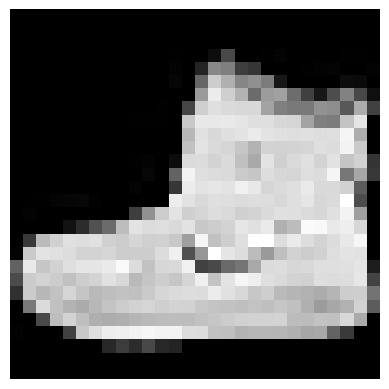

In [12]:
plt.imshow(imgs.squeeze(), cmap='gray')
plt.axis('off')

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss

https://ryanwingate.com/intro-to-machine-learning/deep-learning-with-pytorch/classifying-fashion-mnist/

Deep Learning with PyTorch, Capitulo 7

In [19]:
labels_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

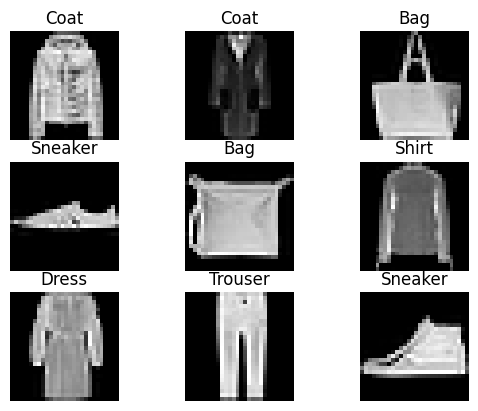

In [20]:
figure = plt.figure()
cols, rows = 3,3

for i in range(1, cols*rows+1):
    j = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[j]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_names[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')

plt.savefig('sample.png', dpi=200, bbox_inches='tight')
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [15]:
# 3.1)
BATH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATH_SIZE, shuffle=True)

In [16]:
# 3.2)
len(train_loader.dataset), len(train_loader)

(60000, 600)

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [22]:
# 4)

class NeuralNetwork(nn.Module):
    def __init__(self, n1, n2, p=0.2):
        super(NeuralNetwork, self).__init__()
        # Capa 0
        self.flatten = nn.Flatten()     #
        
        # Capa 1
        self.fc1 = nn.Linear(28*28, n1) # fully connected
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

        # Capa 2
        self.fc2 = nn.Linear(n1, n2)    # fully connected
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

        # Capa 3        
        self.fc3 = nn.Linear(n2, 10)    # fully connected

    def forward(self, x):
        # Capa 0
        x = self.flatten(x)

        # Capa 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        return x

In [23]:
import torch
import torch.nn as nn
from torchviz import make_dot

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [19]:
# 5.1)
def train_model(dataloader, model, loss_fn, optimizer):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        num_processed_samples += batch_size

        #if batch % (num_batches/10) == 0:
        #if batch % max(num_batches // 10, 1) == 0:
        #    print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
        #          f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

# 5.2)
def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()
            sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')
    return avg_loss, precision

## Baseline

In [24]:
# 5.3)
train_loader = DataLoader(train_data, batch_size=BATH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATH_SIZE, shuffle=True)


# 5.4)
loss_fn = nn.CrossEntropyLoss()


# 5.5)
lr = 1e-3


# 5.6)
n1 = 128
n2 = 64
p = 0.2
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# 5.7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 5.9)
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss, train_precision = train_model(train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

Epoch 1
--------------------
Validation | Precision: 53.3% | Avg Loss: 1.918777
Epoch 2
--------------------
Validation | Precision: 61.0% | Avg Loss: 1.415615
Epoch 3
--------------------
Validation | Precision: 66.4% | Avg Loss: 1.106378
Epoch 4
--------------------
Validation | Precision: 70.0% | Avg Loss: 0.946739
Epoch 5
--------------------
Validation | Precision: 71.9% | Avg Loss: 0.852509
Epoch 6
--------------------
Validation | Precision: 73.2% | Avg Loss: 0.789972
Epoch 7
--------------------
Validation | Precision: 73.7% | Avg Loss: 0.746485
Epoch 8
--------------------
Validation | Precision: 74.7% | Avg Loss: 0.712659
Epoch 9
--------------------
Validation | Precision: 75.3% | Avg Loss: 0.687601
Epoch 10
--------------------
Validation | Precision: 75.6% | Avg Loss: 0.667019
Epoch 11
--------------------
Validation | Precision: 76.3% | Avg Loss: 0.650265
Epoch 12
--------------------
Validation | Precision: 77.0% | Avg Loss: 0.635518
Epoch 13
--------------------
Validat

In [25]:
# guardo el modelo
torch.save(model.state_dict(), 'model_base.pth')

In [21]:
baseline_train_loss = list_train_avg_loss
baseline_valid_loss = list_valid_avg_loss
baseline_train_precision = list_train_precision
baseline_valid_precision = list_valid_precision

NameError: name 'list_train_avg_loss' is not defined

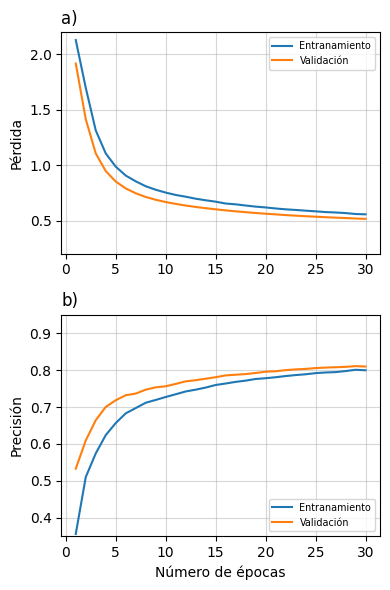

In [27]:
plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)  # Crear un subplot en la posición (1, 1)
plt.title('a)', loc='left')
plt.ylabel('Pérdida')
plt.plot(range(1, len(baseline_train_loss)+1), baseline_train_loss, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_loss)+1), baseline_valid_loss, label=f'Validación')
plt.ylim(0.2, 2.2)
plt.grid(alpha=0.5)
plt.legend(loc='upper right', fontsize='x-small')

plt.subplot(2, 1, 2)  # Crear un subplot en la posición (2, 1)
plt.title('b)', loc='left')
plt.ylabel('Precisión')
plt.plot(range(1, len(baseline_train_precision)+1), baseline_train_precision, label=f'Entranamiento')
plt.plot(range(1, len(baseline_valid_precision)+1), baseline_valid_precision, label=f'Validación')
plt.ylim(0.35, 0.95)
plt.grid(alpha=0.5)
plt.legend(loc='lower right', fontsize='x-small')

plt.xlabel('Número de épocas')  # Agregar el label solo una vez
plt.tight_layout()  # Ajustar el tamaño de los subplots
plt.savefig('baseline.png', dpi=300, bbox_inches='tight')
plt.show()

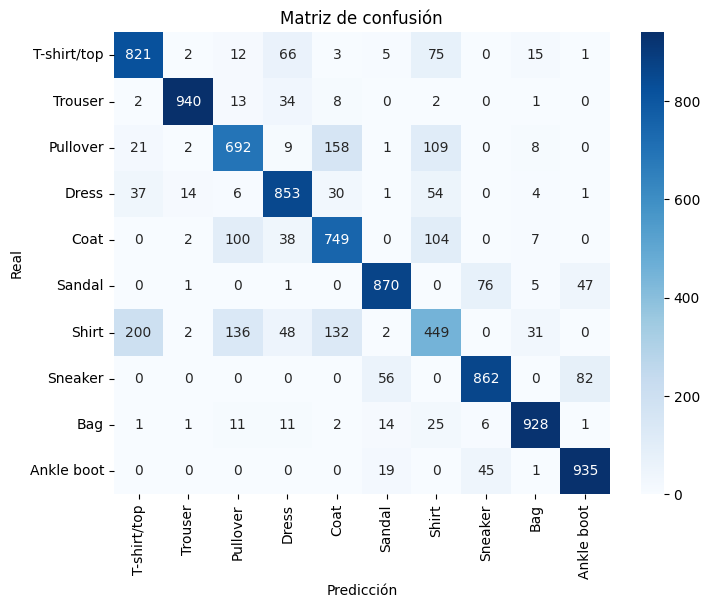

In [46]:
# matriz de confusion
def confusion_matrix(model, dataloader):
    num_samples = len(dataloader.dataset)
    num_classes = 10
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=1)
            for i in range(len(y)):
                confusion_matrix[y[i], pred[i]] += 1
    return confusion_matrix


# grafico de matriz don seaborn
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

labels = [labels_names[i] for i in range(10)]

confusion_matrix = confusion_matrix(model, valid_loader)
plot_confusion_matrix(confusion_matrix, labels)

## Optimizador

In [28]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
model = NeuralNetwork(n1, n2, p=p)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 5.9)
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss, train_precision = train_model(train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

Epoch 1
--------------------
Validation | Precision: 84.2% | Avg Loss: 0.432993
Epoch 2
--------------------
Validation | Precision: 86.3% | Avg Loss: 0.384279
Epoch 3
--------------------
Validation | Precision: 86.0% | Avg Loss: 0.373225
Epoch 4
--------------------
Validation | Precision: 87.1% | Avg Loss: 0.357610
Epoch 5
--------------------
Validation | Precision: 87.4% | Avg Loss: 0.344445
Epoch 6
--------------------
Validation | Precision: 87.5% | Avg Loss: 0.349276
Epoch 7
--------------------
Validation | Precision: 87.5% | Avg Loss: 0.340962
Epoch 8
--------------------
Validation | Precision: 88.2% | Avg Loss: 0.331567
Epoch 9
--------------------
Validation | Precision: 88.1% | Avg Loss: 0.340390
Epoch 10
--------------------
Validation | Precision: 88.3% | Avg Loss: 0.324767
Epoch 11
--------------------
Validation | Precision: 88.3% | Avg Loss: 0.333656
Epoch 12
--------------------
Validation | Precision: 87.8% | Avg Loss: 0.342102
Epoch 13
--------------------
Validat

In [29]:
# guardo el modelo
torch.save(model.state_dict(), 'model_adam.pth')

In [30]:
adam_train_loss = list_train_avg_loss
adam_valid_loss = list_valid_avg_loss
adam_train_precision = list_train_precision
adam_valid_precision = list_valid_precision

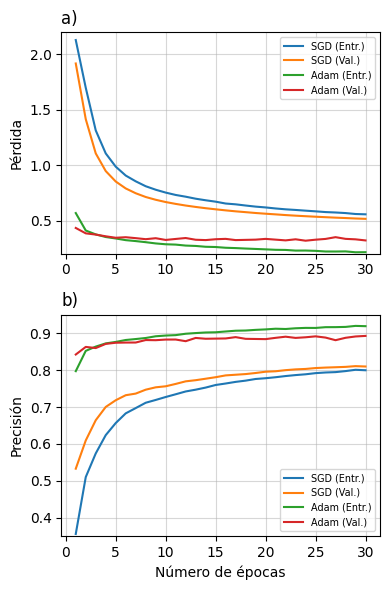

In [31]:
plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)  # Crear un subplot en la posición (1, 1)
plt.title('a)', loc='left')
plt.ylabel('Pérdida')
plt.plot(range(1, len(baseline_train_loss)+1), baseline_train_loss, label=f'SGD (Entr.)')
plt.plot(range(1, len(baseline_valid_loss)+1), baseline_valid_loss, label=f'SGD (Val.)')
plt.plot(range(1, len(adam_train_loss)+1), adam_train_loss, label=f'Adam (Entr.)')
plt.plot(range(1, len(adam_valid_loss)+1), adam_valid_loss, label=f'Adam (Val.)')
plt.ylim(0.2, 2.2)
plt.grid(alpha=0.5)
plt.legend(loc='upper right', fontsize='x-small')

plt.subplot(2, 1, 2)  # Crear un subplot en la posición (2, 1)
plt.title('b)', loc='left')
plt.ylabel('Precisión')
plt.plot(range(1, len(baseline_train_precision)+1), baseline_train_precision, label=f'SGD (Entr.)')
plt.plot(range(1, len(baseline_valid_precision)+1), baseline_valid_precision, label=f'SGD (Val.)')
plt.plot(range(1, len(adam_train_precision)+1), adam_train_precision, label=f'Adam (Entr.)')
plt.plot(range(1, len(adam_valid_precision)+1), adam_valid_precision, label=f'Adam (Val.)')
plt.ylim(0.35, 0.95)
plt.grid(alpha=0.5)
plt.legend(loc='lower right', fontsize='x-small')

plt.xlabel('Número de épocas')  # Agregar el label solo una vez
plt.tight_layout()  # Ajustar el tamaño de los subplots
plt.savefig('optimizer.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_744183/552200003.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_adam.pth'))


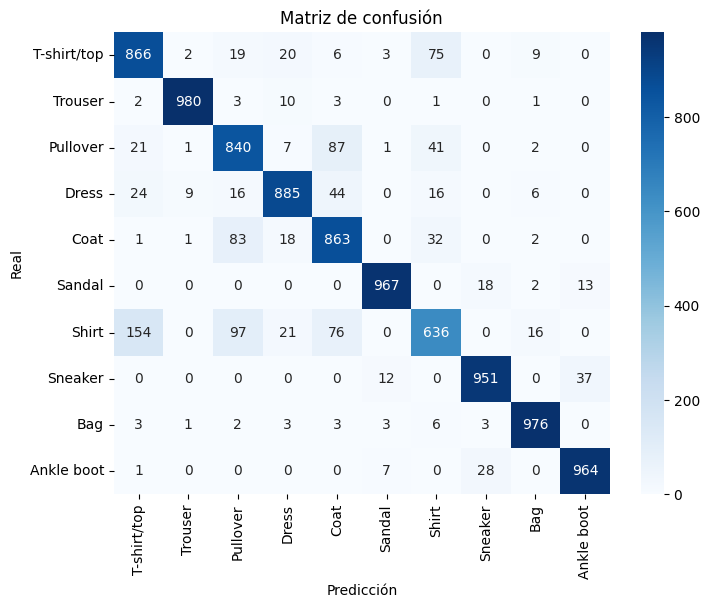

In [51]:
# cargo el modelo con optimizador adam
import seaborn as sns
model = NeuralNetwork(n1, n2, p=p)
model.load_state_dict(torch.load('model_adam.pth'))
model = model.to(device)

# matriz de confusion


def confusion_matrix(model, dataloader):
    num_samples = len(dataloader.dataset)
    num_classes = 10
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=1)
            for i in range(len(y)):
                confusion_matrix[y[i], pred[i]] += 1
    return confusion_matrix


# grafico de matriz don seaborn


def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


labels = [labels_names[i] for i in range(10)]

confusion_matrix = confusion_matrix(model, valid_loader)
plot_confusion_matrix(confusion_matrix, labels)

## Adam con mas epocas 

In [32]:
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
n1 = 128
n2 = 64
p = 0.2
model = NeuralNetwork(n1, n2, p=p)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 5.9)
num_epochs = 60
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)

    train_avg_loss, train_precision = train_model(
        train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

Epoch 1
--------------------
Validation | Precision: 84.2% | Avg Loss: 0.429366
Epoch 2
--------------------
Validation | Precision: 85.7% | Avg Loss: 0.394073
Epoch 3
--------------------
Validation | Precision: 86.4% | Avg Loss: 0.378916
Epoch 4
--------------------
Validation | Precision: 87.5% | Avg Loss: 0.351403
Epoch 5
--------------------
Validation | Precision: 87.7% | Avg Loss: 0.344531
Epoch 6
--------------------
Validation | Precision: 88.0% | Avg Loss: 0.336106
Epoch 7
--------------------
Validation | Precision: 87.8% | Avg Loss: 0.331998
Epoch 8
--------------------
Validation | Precision: 88.1% | Avg Loss: 0.331340
Epoch 9
--------------------
Validation | Precision: 88.6% | Avg Loss: 0.328201
Epoch 10
--------------------
Validation | Precision: 88.1% | Avg Loss: 0.337968
Epoch 11
--------------------
Validation | Precision: 88.0% | Avg Loss: 0.340426
Epoch 12
--------------------
Validation | Precision: 88.1% | Avg Loss: 0.332018
Epoch 13
--------------------
Validat

In [33]:
# guardo el modelo
torch.save(model.state_dict(), 'model_adam_60.pth')

In [34]:
adam60_train_loss = list_train_avg_loss
adam60_valid_loss = list_valid_avg_loss
adam60_train_precision = list_train_precision
adam60_valid_precision = list_valid_precision

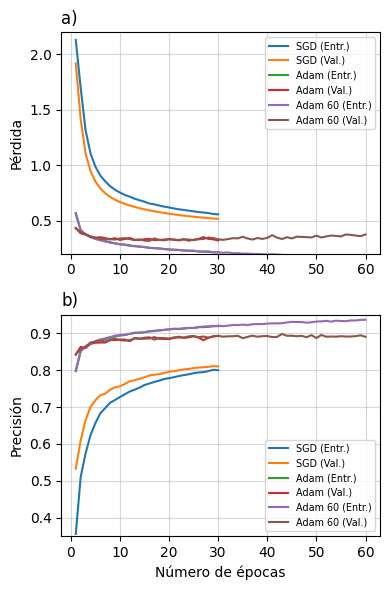

In [35]:
plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)  # Crear un subplot en la posición (1, 1)
plt.title('a)', loc='left')
plt.ylabel('Pérdida')
plt.plot(range(1, len(baseline_train_loss)+1), baseline_train_loss, label=f'SGD (Entr.)')
plt.plot(range(1, len(baseline_valid_loss)+1), baseline_valid_loss, label=f'SGD (Val.)')
plt.plot(range(1, len(adam_train_loss)+1), adam_train_loss, label=f'Adam (Entr.)')
plt.plot(range(1, len(adam_valid_loss)+1), adam_valid_loss, label=f'Adam (Val.)')
plt.plot(range(1, len(adam60_train_loss)+1), adam60_train_loss, label=f'Adam 60 (Entr.)')
plt.plot(range(1, len(adam60_valid_loss)+1), adam60_valid_loss, label=f'Adam 60 (Val.)')
plt.ylim(0.2, 2.2)
plt.grid(alpha=0.5)
plt.legend(loc='upper right', fontsize='x-small')

plt.subplot(2, 1, 2)  # Crear un subplot en la posición (2, 1)
plt.title('b)', loc='left')
plt.ylabel('Precisión')
plt.plot(range(1, len(baseline_train_precision)+1), baseline_train_precision, label=f'SGD (Entr.)')
plt.plot(range(1, len(baseline_valid_precision)+1), baseline_valid_precision, label=f'SGD (Val.)')
plt.plot(range(1, len(adam_train_precision)+1), adam_train_precision, label=f'Adam (Entr.)')
plt.plot(range(1, len(adam_valid_precision)+1), adam_valid_precision, label=f'Adam (Val.)')
plt.plot(range(1, len(adam60_train_precision)+1), adam60_train_precision, label=f'Adam 60 (Entr.)')
plt.plot(range(1, len(adam60_valid_precision)+1), adam60_valid_precision, label=f'Adam 60 (Val.)')
plt.ylim(0.35, 0.95)
plt.grid(alpha=0.5)
plt.legend(loc='lower right', fontsize='x-small')

plt.xlabel('Número de épocas')  # Agregar el label solo una vez
plt.tight_layout()  # Ajustar el tamaño de los subplots
plt.savefig('optimizer.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_744183/1919070900.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_adam_60.pth'))


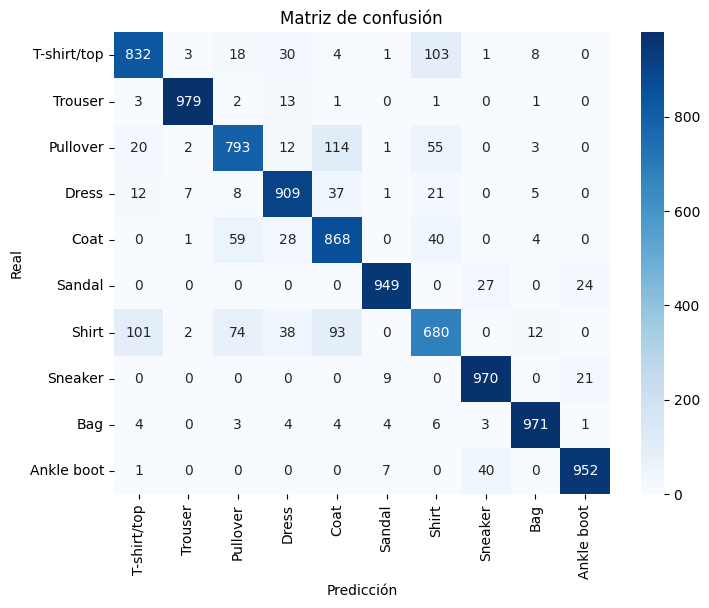

In [52]:
# cargo el modelo con optimizador adam
import seaborn as sns
model = NeuralNetwork(n1, n2, p=p)
model.load_state_dict(torch.load('model_adam_60.pth'))
model = model.to(device)

# matriz de confusion


def confusion_matrix(model, dataloader):
    num_samples = len(dataloader.dataset)
    num_classes = 10
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=1)
            for i in range(len(y)):
                confusion_matrix[y[i], pred[i]] += 1
    return confusion_matrix


# grafico de matriz don seaborn


def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='g',
                cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


labels = [labels_names[i] for i in range(10)]

confusion_matrix = confusion_matrix(model, valid_loader)
plot_confusion_matrix(confusion_matrix, labels)